In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from pathlib import Path

# check if workding_dir is in local variables
if "workding_dir" not in locals():
    workding_dir = str(Path.cwd().parent)

os.chdir(workding_dir)
sys.path.append(workding_dir)
print("workding dir:", workding_dir)

workding dir: /Users/inflaton/code/engd/projects/logical-reasoning


In [3]:
from dotenv import find_dotenv, load_dotenv

found_dotenv = find_dotenv(".env")

if len(found_dotenv) == 0:
    found_dotenv = find_dotenv(".env.example")
print(f"loading env vars from: {found_dotenv}")
load_dotenv(found_dotenv, override=True)

loading env vars from: /Users/inflaton/code/engd/projects/logical-reasoning/.env


True

In [4]:
import os

model_name = os.getenv("MODEL_NAME")
data_path = os.getenv("LOGICAL_REASONING_DATA_PATH")
results_path = os.getenv("LOGICAL_REASONING_RESULTS_PATH")
max_new_tokens = int(os.getenv("MAX_NEW_TOKENS", 2048))

print(model_name,data_path, results_path, max_new_tokens)

internlm/internlm2_5-7b-chat-1m datasets/mgtv data/openai_results.csv 2048


In [5]:
from llm_toolkit.llm_utils import *
from llm_toolkit.logical_reasoning_utils import *

device = check_gpu()

loading /Users/inflaton/code/engd/projects/logical-reasoning/llm_toolkit/logical_reasoning_utils.py
MPS is available


In [6]:
datasets = load_logical_reasoning_dataset(data_path)

loading train/test data files
DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'answer', 'title', 'puzzle', 'truth'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label', 'answer', 'title', 'puzzle', 'truth'],
        num_rows: 3000
    })
})


In [7]:
eval_dataset = datasets["test"].select([0, 100]).to_pandas()
print_row_details(eval_dataset, range(len(eval_dataset)))

--------------------------------------------------
text: 甄加索是自杀吗
--------------------------------------------------
label: 不是
--------------------------------------------------
answer: nan
--------------------------------------------------
title: 海岸之谜
--------------------------------------------------
puzzle: 在远离城市喧嚣的海边小屋，一天清晨，邻居发现甄加索僵卧在沙滩上，已无生命迹象。现场没有发现任何打斗的迹象。请问甄加索的死因是什么？
--------------------------------------------------
truth: 甄加索是一位热爱自然的画家，他每年都会来到这个海边小屋寻找灵感。在他生命的最后几天，他一直在创作一幅描绘海洋生物的画作。在画即将完成的前一天晚上，他骑着自行车外出，打算在海边观赏夜景。然而，他在沙滩上意外发现了一只搁浅的海豚，为了救助这只海豚，他耗费了极大的体力，最终成功将其送回海中。筋疲力尽的甄加索在沙滩上睡着了，由于他患有严重的心脏病，却未告知旁人，在寒冷的海风中，他的心脏停止了跳动。因此，警方在现场只发现了车轮痕迹和未完成的画作，而没有发现任何他杀的迹象。
--------------------------------------------------
text: 背包主人是来湖边放生的吗
--------------------------------------------------
label: 不是
--------------------------------------------------
answer: nan
--------------------------------------------------
title: 湖畔迷影
--------------------------------------------------
puzzle: 一个宁静的午后，湖边突然传来了

In [8]:
prompt = get_prompt_template(using_p1=False, chinese_prompt=False)
print(prompt)

You are the host of a situational guessing game. The rules of the game are as follows:

1. Participants will receive a riddle that describes a simple yet difficult to understand event.
2. The host knows the truth, which is the solution to the riddle.
3. Participants can ask any closed-ended questions to uncover the truth of the event.
4. For each question, the host will respond with one of the following five options based on the actual situation: Yes, No, Unimportant, Correct answer, or Incorrect questioning. The criteria for each response are as follows:
   - If the riddle and answer can provide an answer to the question, respond with: Yes or No
   - If the riddle and answer cannot directly or indirectly infer an answer to the question, respond with: Unimportant
   - If the participant's question is not a closed-ended question or is difficult to understand, respond with: Incorrect questioning
   - If the participant's question essentially reveals the truth of the answer, respond with:

In [9]:
prompt = get_prompt_template(using_p1=False, chinese_prompt=True)
print(prompt)

你是一个情景猜谜游戏的主持人。游戏规则如下：

1. 参与者会得到一个谜面，谜面会描述一个简单又难以理解的事件。
2. 主持人知道谜底，谜底是谜面的答案。
3. 参与者可以询问任何封闭式问题来找寻事件的真相。
4. 对于每个问题，主持人将根据实际情况回答以下五个选项之一：是、不是、不重要、回答正确、问法错误。各回答的判断标准如下：
   - 若谜面和谜底能找到问题的答案，回答：是或者不是
   - 若谜面和谜底不能直接或者间接推断出问题的答案，回答：不重要
   - 若参与者提问不是一个封闭式问题或者问题难以理解，回答：问法错误
   - 若参与者提问基本还原了谜底真相，回答：回答正确
5. 回答中不能添加任何其它信息，也不能省略选项中的任何一个字。例如，不可以把“不是”省略成“不”。

请严格按照这些规则回答参与者提出的问题。

谜面: {}
谜底: {}
参与者提出的问题: {}
回答: 



In [10]:
get_few_shot_prompt_template(5, datasets["train"].to_pandas(), debug=True)

num_shots: 5
labels: ['不是' '不重要' '是' '问法错误' '回答正确']
P2_few_shot: 你是一个情景猜谜游戏的主持人。游戏规则如下：

1. 参与者会得到一个谜面，谜面会描述一个简单又难以理解的事件。
2. 主持人知道谜底，谜底是谜面的答案。
3. 参与者可以询问任何封闭式问题来找寻事件的真相。
4. 对于每个问题，主持人将根据实际情况回答以下五个选项之一：是、不是、不重要、回答正确、问法错误。各回答的判断标准如下：
   - 若谜面和谜底能找到问题的答案，回答：是或者不是
   - 若谜面和谜底不能直接或者间接推断出问题的答案，回答：不重要
   - 若参与者提问不是一个封闭式问题或者问题难以理解，回答：问法错误
   - 若参与者提问基本还原了谜底真相，回答：回答正确
5. 回答中不能添加任何其它信息，也不能省略选项中的任何一个字。例如，不可以把“不是”省略成“不”。

请严格按照这些规则回答参与者提出的问题。

示例输入和输出: 
谜面: 在甄家村里，有一个古老的传说：每年南瓜丰收的季节，南瓜田里总有一个最大的南瓜会不翼而飞，村民们对此现象困惑不解。请找出南瓜失踪背后的原因。
谜底: 真相原来与一位年迈的农夫有关。这位农夫年轻时，曾与一位美丽的姑娘相恋。他们约定在南瓜丰收的季节结婚。然而，命运弄人，姑娘在婚礼前的一场意外中离世。悲伤的农夫为了纪念心爱的姑娘，每年都会将最大的南瓜偷走，放到姑娘的墓前，以此寄托自己的哀思。这一行为延续了多年，成为了乡村里一个神秘的传说。
参与者提出的问题: 偷的人信神吗
回答: 不是

谜面: 在甄家村里，有一个古老的传说：每年南瓜丰收的季节，南瓜田里总有一个最大的南瓜会不翼而飞，村民们对此现象困惑不解。请找出南瓜失踪背后的原因。
谜底: 真相原来与一位年迈的农夫有关。这位农夫年轻时，曾与一位美丽的姑娘相恋。他们约定在南瓜丰收的季节结婚。然而，命运弄人，姑娘在婚礼前的一场意外中离世。悲伤的农夫为了纪念心爱的姑娘，每年都会将最大的南瓜偷走，放到姑娘的墓前，以此寄托自己的哀思。这一行为延续了多年，成为了乡村里一个神秘的传说。
参与者提出的问题: 村庄里的人喜欢南瓜嘛
回答: 不重要

谜面: 在甄家村里，有一个古老的传说：每年南瓜丰收的季节，南瓜田里总有一个最大的南瓜会不翼而飞，村民们对此现象

'你是一个情景猜谜游戏的主持人。游戏规则如下：\n\n1. 参与者会得到一个谜面，谜面会描述一个简单又难以理解的事件。\n2. 主持人知道谜底，谜底是谜面的答案。\n3. 参与者可以询问任何封闭式问题来找寻事件的真相。\n4. 对于每个问题，主持人将根据实际情况回答以下五个选项之一：是、不是、不重要、回答正确、问法错误。各回答的判断标准如下：\n   - 若谜面和谜底能找到问题的答案，回答：是或者不是\n   - 若谜面和谜底不能直接或者间接推断出问题的答案，回答：不重要\n   - 若参与者提问不是一个封闭式问题或者问题难以理解，回答：问法错误\n   - 若参与者提问基本还原了谜底真相，回答：回答正确\n5. 回答中不能添加任何其它信息，也不能省略选项中的任何一个字。例如，不可以把“不是”省略成“不”。\n\n请严格按照这些规则回答参与者提出的问题。\n\n示例输入和输出: \n谜面: 在甄家村里，有一个古老的传说：每年南瓜丰收的季节，南瓜田里总有一个最大的南瓜会不翼而飞，村民们对此现象困惑不解。请找出南瓜失踪背后的原因。\n谜底: 真相原来与一位年迈的农夫有关。这位农夫年轻时，曾与一位美丽的姑娘相恋。他们约定在南瓜丰收的季节结婚。然而，命运弄人，姑娘在婚礼前的一场意外中离世。悲伤的农夫为了纪念心爱的姑娘，每年都会将最大的南瓜偷走，放到姑娘的墓前，以此寄托自己的哀思。这一行为延续了多年，成为了乡村里一个神秘的传说。\n参与者提出的问题: 偷的人信神吗\n回答: 不是\n\n谜面: 在甄家村里，有一个古老的传说：每年南瓜丰收的季节，南瓜田里总有一个最大的南瓜会不翼而飞，村民们对此现象困惑不解。请找出南瓜失踪背后的原因。\n谜底: 真相原来与一位年迈的农夫有关。这位农夫年轻时，曾与一位美丽的姑娘相恋。他们约定在南瓜丰收的季节结婚。然而，命运弄人，姑娘在婚礼前的一场意外中离世。悲伤的农夫为了纪念心爱的姑娘，每年都会将最大的南瓜偷走，放到姑娘的墓前，以此寄托自己的哀思。这一行为延续了多年，成为了乡村里一个神秘的传说。\n参与者提出的问题: 村庄里的人喜欢南瓜嘛\n回答: 不重要\n\n谜面: 在甄家村里，有一个古老的传说：每年南瓜丰收的季节，南瓜田里总有一个最大的南瓜会不翼而飞，村民们对此现象困惑不解。请找出南瓜失踪背后的原因。\n谜底: 真相原来与一位年迈的农夫有关。

In [11]:
from langchain_core.globals import set_debug

set_debug(True)

reasoning_with_openai(eval_dataset.iloc[0], prompt, max_tokens=max_new_tokens)

[chain/start] [chain:RunnableSequence] Entering Chain run with input:
{}
[chain/start] [chain:RunnableSequence > prompt:ChatPromptTemplate] Entering Prompt run with input:
{}
[chain/end] [chain:RunnableSequence > prompt:ChatPromptTemplate] s] Exiting Prompt run with output:
[outputs]
[llm/start] [chain:RunnableSequence > llm:ChatOpenAI] Entering LLM run with input:
{
  "prompts": [
    "System: You are an expert in logical reasoning.\nHuman: 你是一个情景猜谜游戏的主持人。游戏规则如下：\n\n1. 参与者会得到一个谜面，谜面会描述一个简单又难以理解的事件。\n2. 主持人知道谜底，谜底是谜面的答案。\n3. 参与者可以询问任何封闭式问题来找寻事件的真相。\n4. 对于每个问题，主持人将根据实际情况回答以下五个选项之一：是、不是、不重要、回答正确、问法错误。各回答的判断标准如下：\n   - 若谜面和谜底能找到问题的答案，回答：是或者不是\n   - 若谜面和谜底不能直接或者间接推断出问题的答案，回答：不重要\n   - 若参与者提问不是一个封闭式问题或者问题难以理解，回答：问法错误\n   - 若参与者提问基本还原了谜底真相，回答：回答正确\n5. 回答中不能添加任何其它信息，也不能省略选项中的任何一个字。例如，不可以把“不是”省略成“不”。\n\n请严格按照这些规则回答参与者提出的问题。\n\n谜面: 在远离城市喧嚣的海边小屋，一天清晨，邻居发现甄加索僵卧在沙滩上，已无生命迹象。现场没有发现任何打斗的迹象。请问甄加索的死因是什么？\n谜底: 甄加索是一位热爱自然的画家，他每年都会来到这个海边小屋寻找灵感。在他生命的最后几天，他一直在创作一幅描绘海洋生物的画作。在画即将完成的前一天晚上，他骑着自行车外出，打算在海边观赏夜景。然而

'不是'

In [12]:
reasoning_with_openai(eval_dataset.iloc[-1], prompt, model="gpt-4o", max_tokens=max_new_tokens)

[chain/start] [chain:RunnableSequence] Entering Chain run with input:
{}
[chain/start] [chain:RunnableSequence > prompt:ChatPromptTemplate] Entering Prompt run with input:
{}
[chain/end] [chain:RunnableSequence > prompt:ChatPromptTemplate] s] Exiting Prompt run with output:
[outputs]
[llm/start] [chain:RunnableSequence > llm:ChatOpenAI] Entering LLM run with input:
{
  "prompts": [
    "System: You are an expert in logical reasoning.\nHuman: 你是一个情景猜谜游戏的主持人。游戏规则如下：\n\n1. 参与者会得到一个谜面，谜面会描述一个简单又难以理解的事件。\n2. 主持人知道谜底，谜底是谜面的答案。\n3. 参与者可以询问任何封闭式问题来找寻事件的真相。\n4. 对于每个问题，主持人将根据实际情况回答以下五个选项之一：是、不是、不重要、回答正确、问法错误。各回答的判断标准如下：\n   - 若谜面和谜底能找到问题的答案，回答：是或者不是\n   - 若谜面和谜底不能直接或者间接推断出问题的答案，回答：不重要\n   - 若参与者提问不是一个封闭式问题或者问题难以理解，回答：问法错误\n   - 若参与者提问基本还原了谜底真相，回答：回答正确\n5. 回答中不能添加任何其它信息，也不能省略选项中的任何一个字。例如，不可以把“不是”省略成“不”。\n\n请严格按照这些规则回答参与者提出的问题。\n\n谜面: 一个宁静的午后，湖边突然传来了惊叫声。人们跑过去发现，湖边石头上静静躺着一个打翻的背包和一张奇怪的纸条。纸条上写着：“它就在这里，但我无法带它回去。”人们搜寻了周围，但什么也没有发现，背包的主人也不知所踪。\n谜底: 原来，湖边是一个学校的生物研究小组经常进行野外考察的地方。背包的主人是一位对湖中生物充满好奇的学生。他在湖边发现

'不是。'

In [13]:
eval_dataset

text label  answer title  \
0       甄加索是自杀吗    不是     NaN  海岸之谜   
1  背包主人是来湖边放生的吗    不是     NaN  湖畔迷影   

                                              puzzle  \
0  在远离城市喧嚣的海边小屋，一天清晨，邻居发现甄加索僵卧在沙滩上，已无生命迹象。现场没有发现任...   
1  一个宁静的午后，湖边突然传来了惊叫声。人们跑过去发现，湖边石头上静静躺着一个打翻的背包和一张...   

                                               truth  
0  甄加索是一位热爱自然的画家，他每年都会来到这个海边小屋寻找灵感。在他生命的最后几天，他一直在...  
1  原来，湖边是一个学校的生物研究小组经常进行野外考察的地方。背包的主人是一位对湖中生物充满好奇...

In [14]:
set_debug(False)
predictions = eval_openai(eval_dataset)

user_prompt: 你是一个情景猜谜游戏的主持人。游戏规则如下：

1. 参与者会得到一个谜面，谜面会描述一个简单又难以理解的事件。
2. 主持人知道谜底，谜底是谜面的答案。
3. 参与者可以询问任何封闭式问题来找寻事件的真相。
4. 对于每个问题，主持人将根据实际情况回答以下五个选项之一：是、不是、不重要、回答正确、问法错误。各回答的判断标准如下：
   - 若谜面和谜底能找到问题的答案，回答：是或者不是
   - 若谜面和谜底不能直接或者间接推断出问题的答案，回答：不重要
   - 若参与者提问不是一个封闭式问题或者问题难以理解，回答：问法错误
   - 若参与者提问基本还原了谜底真相，回答：回答正确
5. 回答中不能添加任何其它信息，也不能省略选项中的任何一个字。例如，不可以把“不是”省略成“不”。

请严格按照这些规则回答参与者提出的问题。

谜面: {}
谜底: {}
参与者提出的问题: {}
回答: 



100%|██████████| 2/2 [00:01<00:00,  1.71it/s]


In [15]:
predictions

['不是', '不是']

In [16]:
calc_metrics(eval_dataset["label"], predictions)

{'accuracy': 1.0,
 'precision': 1.0,
 'recall': 1.0,
 'f1': 1.0,
 'ratio_valid_classifications': 1.0}

In [17]:
from llm_toolkit.eval_openai import evaluate_model_with_num_shots


loading env vars from: /Users/inflaton/code/engd/projects/logical-reasoning/.env
Adding /Users/inflaton/code/engd/projects/logical-reasoning to sys.path
internlm/internlm2_5-7b-chat-1m datasets/mgtv data/openai_results.csv 2048


In [18]:
results_path

'data/openai_results.csv'

In [19]:
%%time

model_name = "gpt-4o-mini"
evaluate_model_with_num_shots(
    model_name,
    datasets,
    results_path=results_path,
    range_num_shots=[5],
    max_new_tokens=max_new_tokens,
)

Evaluating model: gpt-4o-mini
--------------------------------------------------
text: 甄加索是自杀吗
--------------------------------------------------
label: 不是
--------------------------------------------------
answer: nan
--------------------------------------------------
title: 海岸之谜
--------------------------------------------------
puzzle: 在远离城市喧嚣的海边小屋，一天清晨，邻居发现甄加索僵卧在沙滩上，已无生命迹象。现场没有发现任何打斗的迹象。请问甄加索的死因是什么？
--------------------------------------------------
truth: 甄加索是一位热爱自然的画家，他每年都会来到这个海边小屋寻找灵感。在他生命的最后几天，他一直在创作一幅描绘海洋生物的画作。在画即将完成的前一天晚上，他骑着自行车外出，打算在海边观赏夜景。然而，他在沙滩上意外发现了一只搁浅的海豚，为了救助这只海豚，他耗费了极大的体力，最终成功将其送回海中。筋疲力尽的甄加索在沙滩上睡着了，由于他患有严重的心脏病，却未告知旁人，在寒冷的海风中，他的心脏停止了跳动。因此，警方在现场只发现了车轮痕迹和未完成的画作，而没有发现任何他杀的迹象。
*** Evaluating with num_shots: 5
user_prompt: 你是一个情景猜谜游戏的主持人。游戏规则如下：

1. 参与者会得到一个谜面，谜面会描述一个简单又难以理解的事件。
2. 主持人知道谜底，谜底是谜面的答案。
3. 参与者可以询问任何封闭式问题来找寻事件的真相。
4. 对于每个问题，主持人将根据实际情况回答以下五个选项之一：是、不是、不重要、回答正确、问法错误。各回答的判断标准如下：
   - 若谜面和谜底能找到问题的答案，回答：是或者不是
   - 若谜面和谜底不能直接或者间接推断出问题的答案，回答：不重要
   - 若参与者提问不是一个封闭式问题或者问题

100%|██████████| 3000/3000 [32:19<00:00,  1.55it/s] 

gpt-4o-mini/shots-05 metrics: {'accuracy': 0.7176666666666667, 'incorrect_ids': [4, 9, 11, 12, 17, 18, 21, 23, 25, 26, 27, 28, 29, 31, 33, 35, 37, 38, 43, 53, 55, 58, 59, 63, 64, 65, 66, 67, 75, 77, 78, 81, 82, 83, 88, 91, 93, 96, 102, 103, 104, 105, 107, 112, 113, 115, 117, 118, 121, 122, 124, 125, 131, 136, 143, 150, 155, 160, 161, 162, 164, 165, 169, 171, 173, 179, 180, 189, 190, 191, 192, 193, 197, 198, 199, 200, 202, 203, 221, 222, 223, 224, 228, 231, 234, 236, 237, 239, 240, 243, 245, 248, 250, 251, 252, 255, 257, 260, 263, 265, 268, 269, 271, 272, 275, 277, 283, 284, 286, 292, 293, 295, 301, 303, 308, 309, 314, 317, 318, 319, 320, 324, 325, 328, 330, 333, 334, 335, 338, 342, 349, 350, 356, 360, 362, 363, 364, 368, 370, 371, 374, 375, 384, 386, 389, 396, 397, 413, 414, 415, 418, 419, 421, 425, 428, 429, 430, 447, 450, 452, 453, 454, 456, 457, 461, 462, 463, 464, 465, 467, 472, 477, 486, 487, 488, 490, 492, 493, 496, 500, 501, 502, 503, 504, 506, 508, 510, 511, 516, 517, 518, 519,

In [20]:
%%time

model_name = "gpt-4o"
evaluate_model_with_num_shots(
    model_name,
    datasets,
    results_path=results_path,
    range_num_shots=[5],
    max_new_tokens=max_new_tokens,
)

loading /Users/inflaton/code/engd/projects/logical-reasoning/llm_toolkit/logical_reasoning_utils.py
Evaluating model: gpt-4o
--------------------------------------------------
text: 甄加索是自杀吗
--------------------------------------------------
label: 不是
--------------------------------------------------
answer: nan
--------------------------------------------------
title: 海岸之谜
--------------------------------------------------
puzzle: 在远离城市喧嚣的海边小屋，一天清晨，邻居发现甄加索僵卧在沙滩上，已无生命迹象。现场没有发现任何打斗的迹象。请问甄加索的死因是什么？
--------------------------------------------------
truth: 甄加索是一位热爱自然的画家，他每年都会来到这个海边小屋寻找灵感。在他生命的最后几天，他一直在创作一幅描绘海洋生物的画作。在画即将完成的前一天晚上，他骑着自行车外出，打算在海边观赏夜景。然而，他在沙滩上意外发现了一只搁浅的海豚，为了救助这只海豚，他耗费了极大的体力，最终成功将其送回海中。筋疲力尽的甄加索在沙滩上睡着了，由于他患有严重的心脏病，却未告知旁人，在寒冷的海风中，他的心脏停止了跳动。因此，警方在现场只发现了车轮痕迹和未完成的画作，而没有发现任何他杀的迹象。
*** Evaluating with num_shots: 5
user_prompt: 你是一个情景猜谜游戏的主持人。游戏规则如下：

1. 参与者会得到一个谜面，谜面会描述一个简单又难以理解的事件。
2. 主持人知道谜底，谜底是谜面的答案。
3. 参与者可以询问任何封闭式问题来找寻事件的真相。
4. 对于每个问题，主持人将根据实际情况回答以下五个选项之一：是、不是、不重要、回答正确、问法错误。各回答的判

100%|██████████| 3000/3000 [28:06<00:00,  1.78it/s]  

gpt-4o/shots-05 metrics: {'accuracy': 0.7873333333333333, 'incorrect_ids': [9, 11, 12, 18, 19, 29, 31, 35, 43, 59, 61, 65, 67, 77, 78, 81, 83, 84, 88, 91, 93, 97, 104, 105, 106, 112, 115, 117, 118, 120, 121, 124, 131, 136, 137, 139, 143, 150, 161, 163, 164, 179, 190, 192, 199, 200, 202, 224, 229, 243, 245, 248, 250, 251, 255, 257, 259, 260, 262, 263, 265, 268, 269, 271, 272, 276, 277, 283, 286, 292, 293, 299, 304, 314, 317, 321, 323, 326, 330, 333, 334, 335, 342, 350, 355, 356, 357, 360, 362, 368, 370, 371, 373, 374, 377, 384, 389, 397, 410, 414, 421, 429, 430, 447, 450, 451, 454, 456, 457, 458, 461, 467, 471, 476, 484, 487, 488, 492, 493, 494, 495, 501, 502, 503, 504, 507, 508, 510, 511, 512, 517, 519, 520, 528, 536, 540, 553, 560, 570, 571, 579, 580, 581, 589, 591, 593, 596, 598, 601, 613, 614, 621, 622, 625, 628, 629, 632, 633, 636, 644, 647, 666, 671, 674, 680, 682, 692, 695, 702, 707, 708, 718, 720, 721, 727, 729, 730, 734, 740, 754, 758, 768, 770, 771, 773, 774, 778, 785, 788, 79

In [21]:
%%time

for model_name in ["gpt-4o-mini", "gpt-4o"]:
    evaluate_model_with_num_shots(
        model_name,
        datasets,
        results_path=results_path,
        range_num_shots=[10, 20, 30, 40, 50],
        max_new_tokens=max_new_tokens,
    )

Evaluating model: gpt-4o-mini
--------------------------------------------------
text: 甄加索是自杀吗
--------------------------------------------------
label: 不是
--------------------------------------------------
answer: nan
--------------------------------------------------
title: 海岸之谜
--------------------------------------------------
puzzle: 在远离城市喧嚣的海边小屋，一天清晨，邻居发现甄加索僵卧在沙滩上，已无生命迹象。现场没有发现任何打斗的迹象。请问甄加索的死因是什么？
--------------------------------------------------
truth: 甄加索是一位热爱自然的画家，他每年都会来到这个海边小屋寻找灵感。在他生命的最后几天，他一直在创作一幅描绘海洋生物的画作。在画即将完成的前一天晚上，他骑着自行车外出，打算在海边观赏夜景。然而，他在沙滩上意外发现了一只搁浅的海豚，为了救助这只海豚，他耗费了极大的体力，最终成功将其送回海中。筋疲力尽的甄加索在沙滩上睡着了，由于他患有严重的心脏病，却未告知旁人，在寒冷的海风中，他的心脏停止了跳动。因此，警方在现场只发现了车轮痕迹和未完成的画作，而没有发现任何他杀的迹象。
*** Evaluating with num_shots: 10
user_prompt: 你是一个情景猜谜游戏的主持人。游戏规则如下：

1. 参与者会得到一个谜面，谜面会描述一个简单又难以理解的事件。
2. 主持人知道谜底，谜底是谜面的答案。
3. 参与者可以询问任何封闭式问题来找寻事件的真相。
4. 对于每个问题，主持人将根据实际情况回答以下五个选项之一：是、不是、不重要、回答正确、问法错误。各回答的判断标准如下：
   - 若谜面和谜底能找到问题的答案，回答：是或者不是
   - 若谜面和谜底不能直接或者间接推断出问题的答案，回答：不重要
   - 若参与者提问不是一个封闭式问题或者问

100%|██████████| 3000/3000 [32:22<00:00,  1.54it/s]


gpt-4o-mini/shots-10 metrics: {'accuracy': 0.679, 'incorrect_ids': [4, 5, 9, 11, 12, 18, 21, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34, 35, 36, 37, 38, 53, 55, 63, 65, 66, 67, 68, 71, 72, 75, 76, 77, 78, 80, 81, 82, 83, 84, 88, 91, 93, 94, 96, 101, 102, 103, 104, 105, 107, 111, 112, 113, 115, 117, 118, 121, 122, 123, 124, 125, 127, 131, 136, 143, 144, 150, 155, 160, 161, 162, 164, 165, 169, 171, 173, 174, 175, 178, 179, 180, 188, 189, 190, 191, 192, 193, 197, 198, 200, 202, 203, 214, 220, 221, 222, 224, 225, 226, 228, 230, 231, 233, 234, 236, 237, 238, 239, 240, 241, 243, 245, 248, 250, 251, 252, 255, 257, 260, 263, 264, 265, 268, 269, 270, 271, 272, 275, 277, 282, 283, 284, 286, 292, 293, 294, 295, 301, 303, 305, 306, 308, 309, 314, 315, 317, 318, 320, 321, 323, 328, 330, 333, 334, 335, 338, 340, 347, 348, 349, 350, 356, 358, 359, 360, 362, 363, 364, 368, 370, 371, 372, 373, 374, 376, 378, 384, 386, 389, 393, 395, 396, 397, 402, 404, 408, 413, 414, 417, 418, 419, 421, 423, 425, 428, 430,

100%|██████████| 3000/3000 [42:06<00:00,  1.19it/s]  


gpt-4o-mini/shots-20 metrics: {'accuracy': 0.6623333333333333, 'incorrect_ids': [4, 9, 11, 17, 18, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34, 35, 36, 37, 38, 43, 53, 54, 55, 60, 63, 64, 65, 67, 68, 69, 71, 72, 75, 76, 77, 80, 81, 82, 83, 84, 88, 91, 93, 94, 96, 98, 101, 102, 103, 104, 105, 106, 107, 108, 111, 112, 113, 115, 117, 118, 120, 121, 122, 123, 124, 125, 127, 131, 134, 136, 139, 143, 144, 150, 155, 158, 160, 161, 162, 164, 165, 169, 171, 173, 174, 175, 178, 179, 180, 187, 188, 189, 190, 191, 192, 193, 197, 198, 200, 202, 203, 214, 215, 221, 222, 223, 224, 225, 226, 228, 230, 231, 233, 234, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 248, 250, 251, 252, 255, 257, 260, 263, 264, 265, 268, 269, 270, 271, 272, 275, 277, 280, 281, 282, 283, 284, 292, 293, 294, 295, 301, 303, 305, 306, 308, 314, 317, 318, 320, 321, 323, 328, 330, 333, 334, 335, 338, 340, 347, 348, 349, 350, 353, 355, 356, 358, 359, 360, 362, 363, 364, 368, 369, 370, 371, 372, 373, 374, 375, 376, 378, 384, 386, 38

100%|██████████| 3000/3000 [40:05<00:00,  1.25it/s] 


gpt-4o-mini/shots-30 metrics: {'accuracy': 0.687, 'incorrect_ids': [9, 11, 18, 23, 24, 25, 26, 27, 28, 29, 31, 33, 34, 35, 38, 43, 53, 54, 55, 58, 59, 63, 65, 66, 67, 68, 69, 71, 72, 75, 76, 77, 78, 80, 81, 82, 83, 84, 87, 88, 91, 93, 94, 96, 98, 101, 102, 103, 104, 105, 106, 107, 111, 112, 113, 114, 115, 117, 118, 120, 121, 122, 123, 124, 125, 127, 131, 134, 136, 139, 143, 144, 150, 155, 160, 161, 162, 164, 165, 169, 171, 173, 174, 175, 178, 179, 180, 188, 189, 190, 191, 192, 193, 197, 198, 200, 202, 203, 214, 221, 222, 224, 225, 228, 231, 233, 234, 236, 237, 238, 239, 240, 241, 242, 245, 248, 250, 251, 252, 255, 257, 260, 263, 264, 265, 268, 269, 270, 271, 272, 275, 277, 280, 282, 283, 284, 286, 292, 293, 294, 295, 301, 303, 305, 306, 308, 314, 317, 318, 320, 321, 328, 330, 333, 334, 335, 338, 340, 347, 348, 349, 350, 356, 358, 359, 360, 362, 363, 364, 368, 370, 371, 374, 375, 378, 384, 386, 389, 394, 395, 396, 397, 404, 405, 408, 413, 414, 417, 418, 419, 420, 421, 425, 428, 430, 431

100%|██████████| 3000/3000 [46:04<00:00,  1.09it/s]  


gpt-4o-mini/shots-40 metrics: {'accuracy': 0.692, 'incorrect_ids': [9, 11, 18, 23, 24, 25, 26, 27, 28, 29, 31, 33, 35, 38, 43, 53, 54, 55, 58, 59, 63, 64, 65, 66, 67, 68, 69, 71, 72, 75, 76, 77, 78, 80, 81, 82, 83, 84, 87, 88, 91, 93, 96, 98, 101, 102, 103, 104, 105, 106, 107, 111, 112, 113, 115, 117, 118, 120, 121, 122, 123, 124, 125, 127, 131, 136, 139, 143, 144, 150, 154, 155, 160, 161, 162, 164, 165, 171, 173, 174, 175, 178, 179, 188, 189, 190, 191, 192, 193, 198, 199, 200, 202, 203, 214, 221, 222, 223, 224, 228, 233, 234, 236, 237, 239, 240, 241, 245, 248, 250, 251, 252, 255, 257, 260, 263, 264, 265, 267, 268, 269, 270, 271, 272, 274, 275, 277, 280, 281, 282, 283, 284, 292, 293, 294, 295, 301, 303, 305, 308, 309, 314, 317, 318, 319, 320, 324, 328, 330, 333, 334, 335, 338, 340, 347, 348, 349, 350, 356, 358, 359, 360, 362, 363, 364, 368, 370, 371, 374, 375, 378, 384, 386, 389, 391, 394, 395, 396, 397, 399, 400, 405, 408, 413, 414, 415, 417, 418, 419, 420, 421, 425, 428, 430, 431, 43

100%|██████████| 3000/3000 [49:49<00:00,  1.00it/s]  


gpt-4o-mini/shots-50 metrics: {'accuracy': 0.717, 'incorrect_ids': [9, 11, 14, 18, 23, 25, 26, 28, 29, 31, 33, 35, 38, 53, 55, 58, 59, 63, 64, 65, 66, 67, 71, 72, 75, 76, 77, 78, 80, 81, 82, 83, 84, 87, 88, 91, 93, 96, 97, 101, 102, 103, 104, 105, 106, 111, 112, 113, 115, 117, 118, 121, 122, 123, 124, 125, 127, 131, 134, 136, 139, 143, 144, 150, 154, 155, 160, 161, 162, 164, 165, 171, 173, 174, 175, 178, 179, 188, 189, 190, 191, 192, 193, 198, 199, 200, 202, 203, 214, 215, 220, 221, 222, 224, 228, 233, 234, 236, 237, 238, 240, 245, 248, 250, 251, 252, 255, 257, 260, 263, 264, 265, 268, 269, 270, 271, 272, 274, 275, 277, 280, 281, 282, 283, 284, 292, 293, 295, 301, 303, 305, 308, 309, 314, 317, 318, 319, 320, 328, 330, 333, 334, 335, 338, 340, 348, 349, 350, 356, 360, 362, 363, 364, 368, 370, 371, 374, 375, 378, 384, 386, 387, 389, 394, 395, 396, 397, 400, 405, 413, 414, 415, 417, 418, 419, 420, 421, 428, 430, 431, 436, 447, 450, 451, 452, 453, 454, 457, 459, 460, 461, 463, 464, 465, 46

100%|██████████| 3000/3000 [29:05<00:00,  1.72it/s] 


gpt-4o/shots-10 metrics: {'accuracy': 0.7916666666666666, 'incorrect_ids': [9, 11, 12, 18, 19, 27, 29, 31, 43, 59, 61, 65, 67, 77, 78, 81, 83, 84, 88, 91, 94, 97, 104, 112, 113, 115, 117, 118, 120, 124, 129, 131, 136, 137, 139, 141, 143, 150, 161, 163, 164, 179, 192, 199, 200, 202, 222, 224, 229, 245, 248, 250, 251, 255, 257, 259, 260, 265, 268, 269, 271, 276, 283, 292, 293, 299, 301, 304, 314, 321, 323, 326, 330, 333, 334, 335, 350, 353, 355, 356, 360, 361, 368, 370, 371, 373, 374, 377, 383, 384, 389, 395, 397, 410, 421, 429, 447, 450, 454, 456, 457, 458, 461, 467, 471, 476, 484, 488, 492, 493, 495, 501, 502, 503, 504, 506, 507, 508, 509, 510, 511, 512, 517, 519, 520, 534, 536, 540, 553, 560, 570, 571, 579, 580, 581, 589, 591, 596, 601, 613, 614, 621, 622, 625, 628, 629, 632, 636, 644, 647, 666, 674, 680, 682, 689, 692, 695, 702, 707, 718, 720, 721, 727, 729, 730, 734, 739, 740, 754, 758, 766, 768, 770, 771, 774, 778, 788, 791, 798, 799, 801, 805, 809, 810, 813, 817, 819, 820, 821, 82

 12%|█▏        | 350/3000 [1:15:24<9:30:58, 12.93s/it]


KeyboardInterrupt: 

In [23]:
%%time

model_name ="gpt-4o"

evaluate_model_with_num_shots(
    model_name,
    datasets,
    results_path=results_path,
    range_num_shots=[20, 30, 40, 50],
    max_new_tokens=max_new_tokens,
)

loading /Users/inflaton/code/engd/projects/logical-reasoning/llm_toolkit/logical_reasoning_utils.py
Evaluating model: gpt-4o
--------------------------------------------------
text: 甄加索是自杀吗
--------------------------------------------------
label: 不是
--------------------------------------------------
answer: nan
--------------------------------------------------
title: 海岸之谜
--------------------------------------------------
puzzle: 在远离城市喧嚣的海边小屋，一天清晨，邻居发现甄加索僵卧在沙滩上，已无生命迹象。现场没有发现任何打斗的迹象。请问甄加索的死因是什么？
--------------------------------------------------
truth: 甄加索是一位热爱自然的画家，他每年都会来到这个海边小屋寻找灵感。在他生命的最后几天，他一直在创作一幅描绘海洋生物的画作。在画即将完成的前一天晚上，他骑着自行车外出，打算在海边观赏夜景。然而，他在沙滩上意外发现了一只搁浅的海豚，为了救助这只海豚，他耗费了极大的体力，最终成功将其送回海中。筋疲力尽的甄加索在沙滩上睡着了，由于他患有严重的心脏病，却未告知旁人，在寒冷的海风中，他的心脏停止了跳动。因此，警方在现场只发现了车轮痕迹和未完成的画作，而没有发现任何他杀的迹象。
*** Evaluating with num_shots: 20
user_prompt: 你是一个情景猜谜游戏的主持人。游戏规则如下：

1. 参与者会得到一个谜面，谜面会描述一个简单又难以理解的事件。
2. 主持人知道谜底，谜底是谜面的答案。
3. 参与者可以询问任何封闭式问题来找寻事件的真相。
4. 对于每个问题，主持人将根据实际情况回答以下五个选项之一：是、不是、不重要、回答正确、问法错误。各回答的

100%|██████████| 3000/3000 [33:39<00:00,  1.49it/s] 


gpt-4o/shots-20 metrics: {'accuracy': 0.7813333333333333, 'incorrect_ids': [9, 11, 12, 18, 19, 29, 31, 35, 43, 59, 61, 65, 67, 77, 81, 88, 91, 94, 97, 104, 105, 112, 113, 115, 117, 118, 120, 124, 131, 136, 137, 139, 143, 150, 161, 163, 164, 179, 192, 199, 200, 202, 222, 224, 229, 240, 245, 248, 250, 252, 255, 257, 259, 260, 262, 265, 268, 269, 271, 272, 276, 283, 286, 292, 293, 295, 299, 301, 304, 314, 320, 321, 326, 330, 333, 334, 335, 347, 350, 355, 356, 357, 360, 361, 368, 370, 371, 373, 374, 377, 383, 384, 389, 395, 397, 410, 414, 421, 429, 447, 450, 454, 456, 457, 458, 461, 465, 467, 471, 474, 475, 476, 484, 487, 488, 492, 493, 495, 501, 502, 504, 506, 507, 508, 509, 510, 511, 512, 517, 519, 520, 528, 534, 536, 540, 553, 560, 570, 571, 579, 580, 581, 589, 591, 596, 598, 601, 612, 613, 614, 618, 621, 622, 625, 626, 628, 629, 632, 633, 636, 644, 647, 657, 666, 671, 674, 680, 682, 692, 695, 701, 702, 707, 718, 720, 721, 729, 730, 732, 734, 739, 740, 754, 758, 759, 768, 770, 771, 773,

100%|██████████| 3000/3000 [39:31<00:00,  1.26it/s]  


gpt-4o/shots-30 metrics: {'accuracy': 0.7886666666666666, 'incorrect_ids': [9, 11, 18, 19, 29, 31, 43, 59, 61, 65, 67, 77, 81, 84, 88, 91, 94, 97, 104, 105, 115, 117, 118, 120, 124, 129, 131, 136, 137, 139, 143, 150, 161, 163, 164, 192, 199, 200, 202, 222, 224, 229, 243, 245, 248, 250, 255, 257, 259, 260, 265, 268, 269, 271, 272, 276, 283, 286, 292, 295, 299, 301, 303, 304, 314, 321, 323, 326, 330, 333, 334, 335, 347, 350, 356, 360, 361, 362, 368, 370, 371, 373, 374, 377, 384, 389, 395, 397, 414, 421, 430, 447, 450, 453, 454, 456, 457, 458, 461, 465, 467, 476, 484, 492, 493, 495, 500, 501, 502, 503, 504, 506, 507, 508, 509, 510, 511, 512, 517, 519, 520, 534, 536, 540, 553, 560, 570, 571, 579, 580, 581, 589, 591, 593, 596, 601, 613, 614, 621, 622, 625, 628, 629, 632, 636, 644, 647, 657, 666, 671, 674, 680, 682, 692, 695, 701, 702, 707, 718, 720, 721, 730, 732, 734, 740, 754, 758, 759, 768, 770, 773, 774, 778, 786, 788, 790, 791, 798, 799, 801, 805, 809, 810, 813, 816, 817, 819, 820, 821

100%|██████████| 3000/3000 [42:37<00:00,  1.17it/s]


gpt-4o/shots-40 metrics: {'accuracy': 0.7836666666666666, 'incorrect_ids': [9, 11, 12, 18, 19, 27, 29, 31, 35, 43, 59, 61, 63, 65, 67, 77, 78, 81, 83, 88, 91, 94, 97, 104, 105, 113, 115, 117, 118, 120, 124, 131, 136, 137, 139, 143, 150, 161, 163, 164, 190, 192, 199, 200, 202, 222, 224, 229, 241, 243, 245, 248, 250, 251, 255, 257, 259, 260, 265, 268, 269, 271, 276, 283, 286, 292, 293, 295, 299, 303, 304, 314, 321, 326, 330, 333, 334, 335, 347, 356, 360, 361, 362, 368, 370, 371, 373, 374, 377, 384, 389, 395, 397, 410, 414, 421, 429, 432, 447, 450, 453, 454, 456, 457, 458, 461, 465, 467, 476, 487, 488, 490, 492, 493, 494, 495, 501, 502, 504, 506, 507, 508, 509, 510, 512, 517, 519, 520, 534, 536, 540, 553, 560, 571, 579, 580, 581, 589, 591, 593, 596, 601, 613, 614, 621, 622, 625, 628, 629, 632, 633, 636, 644, 647, 657, 666, 669, 674, 680, 682, 692, 695, 701, 702, 707, 718, 720, 721, 730, 732, 734, 740, 754, 758, 759, 768, 769, 770, 771, 773, 774, 778, 786, 788, 790, 791, 795, 798, 801, 805

100%|██████████| 3000/3000 [51:04<00:00,  1.02s/it] 

gpt-4o/shots-50 metrics: {'accuracy': 0.787, 'incorrect_ids': [9, 11, 18, 19, 29, 31, 35, 36, 43, 59, 63, 65, 67, 77, 81, 83, 88, 91, 94, 97, 104, 105, 112, 115, 117, 118, 120, 124, 129, 131, 136, 137, 139, 143, 150, 161, 163, 164, 190, 192, 199, 200, 202, 222, 224, 229, 243, 245, 248, 250, 257, 259, 260, 262, 265, 269, 271, 272, 276, 283, 286, 292, 295, 299, 303, 304, 314, 321, 323, 326, 330, 333, 334, 335, 340, 342, 347, 350, 355, 356, 360, 368, 370, 371, 373, 374, 375, 376, 377, 383, 384, 389, 395, 397, 410, 414, 421, 445, 447, 450, 453, 454, 456, 457, 458, 461, 465, 467, 471, 476, 487, 488, 492, 493, 494, 501, 502, 504, 506, 507, 508, 509, 510, 511, 512, 517, 519, 520, 528, 534, 536, 540, 553, 560, 570, 571, 579, 580, 581, 589, 591, 596, 598, 599, 601, 613, 614, 621, 622, 625, 626, 628, 629, 632, 636, 641, 644, 647, 657, 666, 674, 680, 682, 692, 695, 701, 702, 707, 708, 718, 720, 721, 730, 732, 734, 740, 754, 758, 768, 770, 771, 773, 774, 778, 786, 788, 791, 795, 801, 805, 809, 810

## Costs

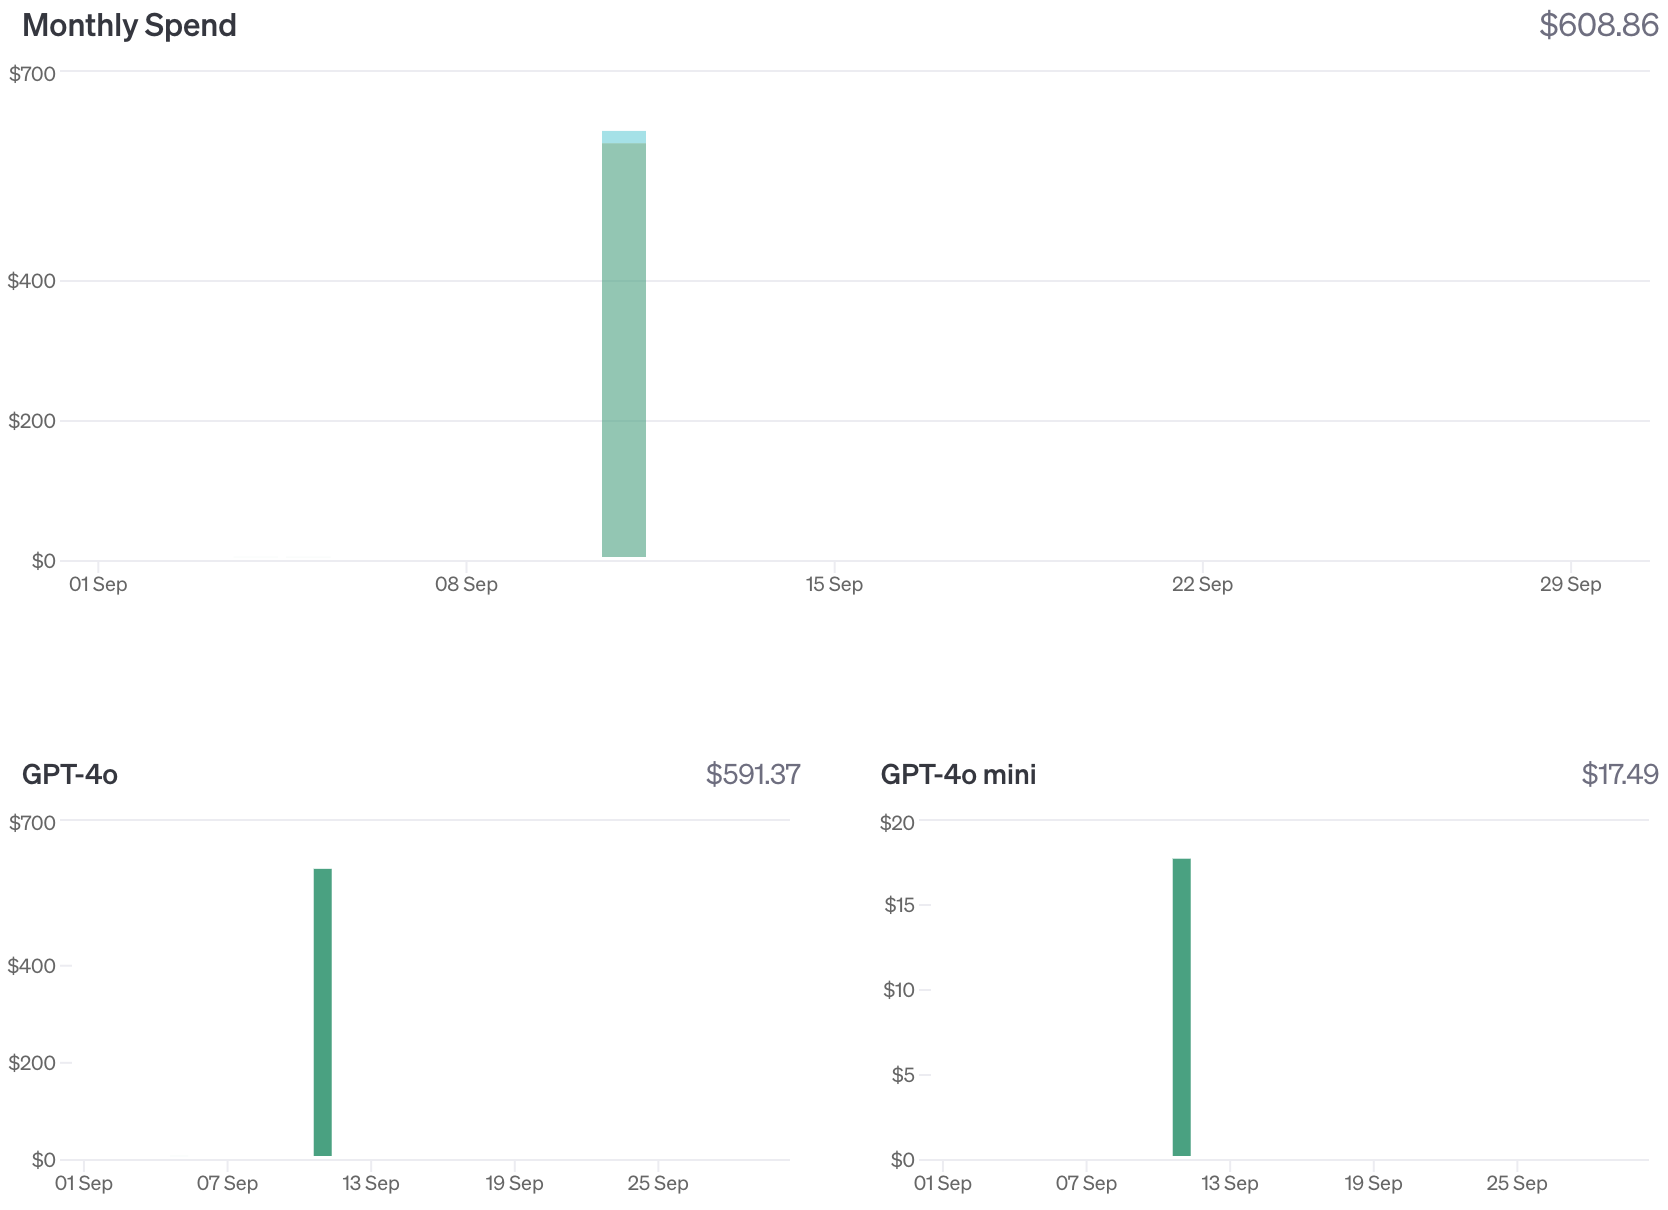